In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAINING_DATA_SET_PATH='/content/drive/MyDrive/finalYear/SinhalaSignLanguage_dataset/training'
VALIDATION_DATA_SET_PATH='/content/drive/MyDrive/finalYear/SinhalaSignLanguage_dataset/testing'
TEST_DATA_PATH='/content/drive/MyDrive/finalYear/SinhalaSignLanguage_dataset/validation'

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from google.colab import files

import pandas as pd
import json
from skimage import transform
from matplotlib import pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import MobileNet, InceptionV3, Xception, InceptionResNetV2,VGG19,ResNet50V2,VGG16,ResNet50

from tensorflow.keras.utils import plot_model


from google.colab.patches import cv2_imshow


In [ ]:
import keras
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,model_from_json
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,MaxPooling2D, GlobalAveragePooling2D
import numpy as np
import pandas as pd
import os
from keras.utils.np_utils import to_categorical
import tensorflow as tf

import os
import cv2
from tqdm import tqdm
import random
import json

import matplotlib.pyplot as plt
import math
import cv2
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.preprocessing.image import img_to_array
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import preprocess_input



In [ ]:
# open and get the constants from the json file
f = open('drive/MyDrive/SDGP/signLang/Constants.json','r', encoding='utf-8')
data = json.load(f)

# number of classes
NUM_CLASSES = 14
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
# number of samples per class
SAMPLES_PER_CLASS = data['SAMPLES_PER_CLASS']

# size of the images to be generated
IMG_SIZE = data['IMG_SIZE']
DATASET_CATEGORIES=14


In [ ]:

# Use data augmentation to generate more training data
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   fill_mode='nearest',
                                   )

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAINING_DATA_SET_PATH,
                                                    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_SET_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
     color_mode='rgb',
    class_mode='categorical')

test_data_generator=test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=False,
         color_mode='rgb',

    class_mode='categorical'
)


Found 7544 images belonging to 14 classes.
Found 846 images belonging to 14 classes.
Found 142 images belonging to 14 classes.


In [ ]:
train_generator[0][0].shape

(32, 224, 224, 3)

In [ ]:
class_labels=train_generator.class_indices
class_labels

{'Aah': 0,
 'Ae': 1,
 'Aee': 2,
 'Aeh': 3,
 'Ah': 4,
 'Ee': 5,
 'Eeh': 6,
 'Ig': 7,
 'K': 8,
 'Oo': 9,
 'Ooh': 10,
 'T': 11,
 'Uh': 12,
 'Uuh': 13}

In [ ]:
validation_generator.class_indices

In [ ]:
# train_path=train_generator.filepaths
# train_path_labels=train_generator.labels




test=test_data_generator.filepaths
test_labels=test_data_generator.labels

# X_train_path, X_test_path, y_train_path, y_test_path = train_test_split(train_path, to_categorical(train_path_labels,len(np.unique(train_path_labels))), test_size=0.2, random_state=0)


In [ ]:
# Define image size
IMG_SIZE = 224
true_labels=[]

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image


def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label


BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data_batch = create_data_batches(X_train_path, y_train_path)
validation_data_batch = create_data_batches(X_test_path, y_test_path, valid_data=True)

In [ ]:
test_data_batch = create_data_batches(test, to_categorical(test_labels,len(np.unique(test_labels))), test_data=True)

Creating test data batches...


In [ ]:
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(list(class_labels.keys())[list(class_labels.values()).index(labels[i].argmax())])
    # Turn gird lines off
    plt.axis("off")

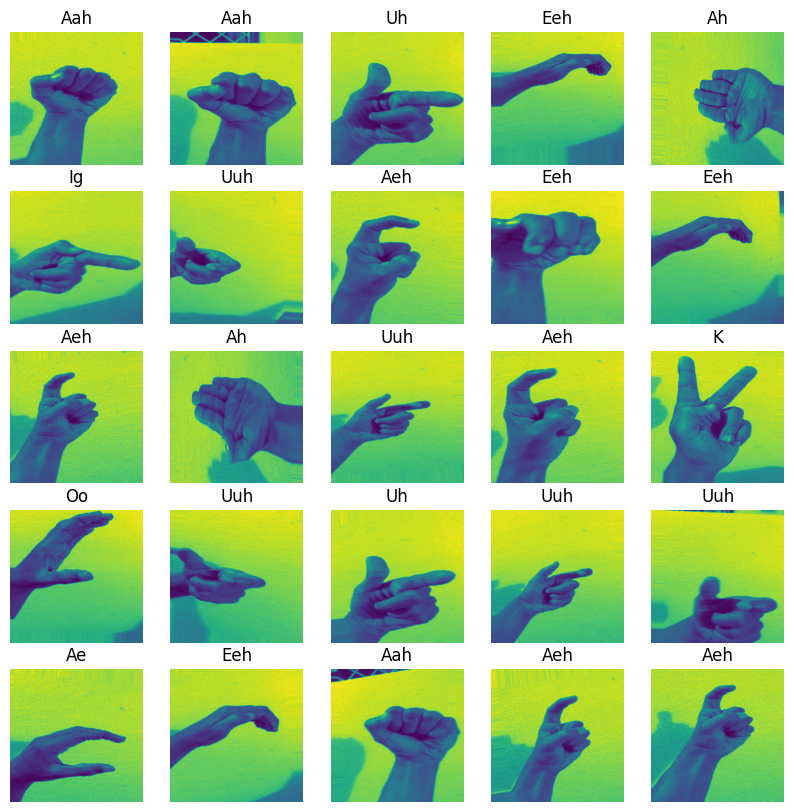

In [ ]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_generator)
show_25_images(train_images, train_labels)

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,3)
                     )
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
from tensorflow.keras.models import Model

def getPreTrainedModel():
    pre_trained_base_model = InceptionResNetV2(weights='imagenet',include_top=False,
                                         input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,3)
                                         )
    pre_trained_base_model.trainable = False


    my_model = pre_trained_base_model.output
    my_model = GlobalAveragePooling2D()(my_model)
    my_model = Dense(32, activation='relu')(
        my_model)  # Add layer
    my_model = Dense(64, activation='relu')(my_model)  # Layer #2
    my_model = Dense(128, activation='relu')(
        my_model)
    my_model = Dense(1024, activation='relu')(
        my_model)
    my_model = Dense(1024, activation='relu')(
        my_model)
    my_model = Dense(512, activation='relu')(my_model)
    my_model = Dense(64, activation='relu')(my_model)  # Layer #2
    final_layer = Dense(DATASET_CATEGORIES, activation='softmax')(
        my_model)
    final_model = Model(inputs=pre_trained_base_model.input, outputs=final_layer)

    return final_model


In [ ]:
def fitModel(model):
    model.compile(optimizer='Adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Checkpoints: save only the best performing model weights as file
    checkpoint = ModelCheckpoint('drive/MyDrive/finalYear/models/model.h5',
                                 monitor='val_accuracy', verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False, mode='max')
    callbacks_list = [checkpoint]

    step_size_training = (train_generator.n // train_generator.batch_size) * 0.7 # smart to use a small learning rate because
    # high learning rates increase the risk of losing previous knowledge.# Balance here to find optimal step_size
    # history = model.fit_generator(generator=train_generator,
    #                               steps_per_epoch=step_size_training,
    #                               epochs=40,
    #                               validation_data=validation_generator,
    #                               validation_steps=validation_generator.n // BATCH_SIZE,
    #                               callbacks=callbacks_list,
    #                               )

    # # Save training history as file. For ex. loss and accuracy in each epoch
    # with open('./output/history.json', 'w') as file:
    #     json.dump(history.history, file)

    return model

In [ ]:
def saveModelToJson(model):
    model_json = model.to_json()
    with open("drive/MyDrive/finalYear/models/modelResnet.json", "w") as json_file:
        json_file.write(model_json)

    print("Model saved as /content/output/model.json")
    #model.save_weights("./output/model-weights.h5")
    #print("Model Weights saved as ./output/model.h5")


In [ ]:
def trainNetwork():
    preTrainedModel = getPreTrainedModel()
    # trimmedModel = freezeLayers(2, preTrainedModel)
    finalModel = fitModel(preTrainedModel)
    # saveModelToJson(finalModel)
    return finalModel

In [ ]:
finalModel = trainNetwork()




In [ ]:
checkpoint = ModelCheckpoint('drive/MyDrive/finalYear/models/model.h5',
                                 monitor='val_accuracy', verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False, mode='max')
callbacks_list = [checkpoint]

step_size_training = (train_generator.n // train_generator.batch_size) * 0.7

history = finalModel.fit(train_generator,
                                  steps_per_epoch=step_size_training,
                                  epochs=30,
                                  validation_data=validation_generator,
                                  validation_steps=validation_generator.n // BATCH_SIZE,
                                  callbacks=callbacks_list,
                                  )

Epoch 1/30
165/164 [==============================] - ETA: -3s - loss: 1.3920 - accuracy: 0.5089
Epoch 1: val_accuracy improved from -inf to 0.76082, saving model to drive/MyDrive/finalYear/models/model.h5
164/164 [==============================] - 1579s 10s/step - loss: 1.3920 - accuracy: 0.5089 - val_loss: 0.6402 - val_accuracy: 0.7608
Epoch 2/30
165/164 [==============================] - ETA: -1s - loss: 0.5373 - accuracy: 0.7995
Epoch 2: val_accuracy improved from 0.76082 to 0.91226, saving model to drive/MyDrive/finalYear/models/model.h5
164/164 [==============================] - 533s 3s/step - loss: 0.5373 - accuracy: 0.7995 - val_loss: 0.3083 - val_accuracy: 0.9123
Epoch 3/30
165/164 [==============================] - ETA: 0s - loss: 0.3331 - accuracy: 0.8881
Epoch 3: val_accuracy improved from 0.91226 to 0.91947, saving model to drive/MyDrive/finalYear/models/model.h5
164/164 [==============================] - 295s 2s/step - loss: 0.3331 - accuracy: 0.8881 - val_loss: 0.2562 - 

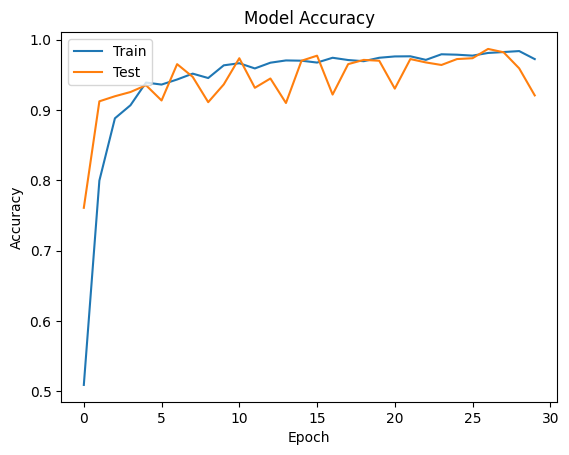

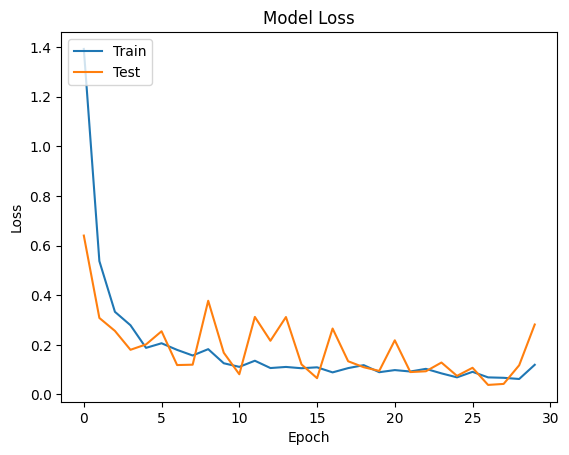

In [ ]:


# Plot the accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#model that we have trained on the mobilenet
# model1 = load_model('drive/MyDrive/finalYear/models/restnet.h5')
# model1 = load_model('drive/MyDrive/finalYear/models/mobilent.h5')
model2 = load_model('drive/MyDrive/finalYear/models/model.h5')
# model3 = load_model('drive/MyDrive/finalYear/models/InceptionV3.h5')
# model4 = load_model('drive/MyDrive/finalYear/models/mobilent.h5')



In [ ]:
model2.save('drive/MyDrive/finalYear/models/model')

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = finalModel.predict(validation_generator, verbose=1) # verbose shows us how long there is to go
predictions
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {list(class_labels.keys())[np.argmax(predictions[0])]}") # the predicted label

9/9 [==============================] - 11s 743ms/step
[9.9980289e-01 9.4999552e-07 7.3491951e-06 5.3146669e-06 1.6897917e-05
 2.8514558e-08 4.4353218e-08 3.6270211e-07 3.6659309e-05 1.2139034e-04
 2.3665298e-06 3.6938621e-07 1.6821313e-06 3.8495518e-06]
Max value (probability of prediction): 0.9998028874397278
Sum: 1.0000001192092896
Max index: 0
Predicted label: Aah


In [ ]:
# evaluate1=model1.evaluate(validation_generator,verbose=1)
evaluate2=model2.evaluate(validation_generator,
                                     verbose=1)



27/27 [==============================] - 29s 699ms/step - loss: 0.0380 - accuracy: 0.9870


In [ ]:
evaluat2e=model2.evaluate(test_data_generator,
                                     verbose=1)

4/4 [==============================] - 19s 1s/step - loss: 0.1263 - accuracy: 0.9444


In [ ]:
predictions = model2.predict(test_data_generator, verbose=1) # verbose shows us how long there is to go
# predictions1 = model1.predict(test_data_generator, verbose=1) # verbose shows us how long there is to go
# predictions2 = model3.predict(test_data_generator, verbose=1) # verbose shows us how long there is to go


5/5 [==============================] - 34s 7s/step


In [ ]:
_, true_labels = zip(*test_data_generator)  # Unzip the labels

# Convert true_labels to a list if needed
# true_labels = list(true_labels)

In [ ]:
true_labels

In [ ]:
target_names = []
for key in test_data_generator.class_indices:
    target_names.append(key)



In [ ]:
print(test_data_generator.classes)

[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13]


In [ ]:
predicted_label = np.argmax(predictions,axis=1)
# predicted_label1 = np.argmax(predictions1,axis=1)
# predicted_label2 = np.argmax(predictions2,axis=1)

actual_label = test_data_generator.classes

In [ ]:
from sklearn.metrics import confusion_matrix

# confusion_matrix(actual_label,predicted_label)

confusion_matrix(test_data_generator.classes, predicted_label)





array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  8]])

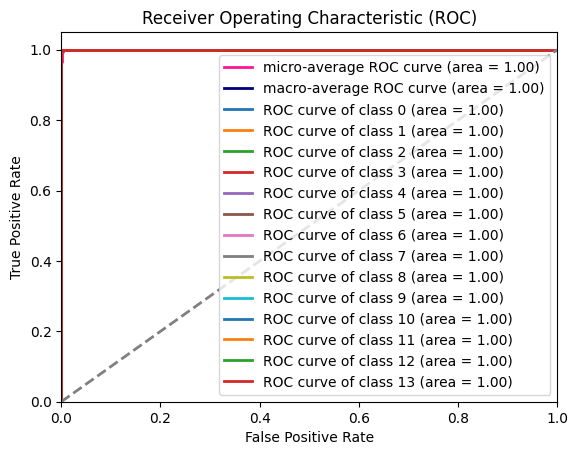

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
num_classes=14
y_true = to_categorical(test_data_generator.labels,len(pd.unique(test_data_generator.labels)))
y_pred = predictions
# y_true: true labels, y_pred: predicted probabilities for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot the ROC curves
plt.figure()
lw = 2
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=lw, label='micro-average ROC curve (area = %0.2f)' % roc_auc_micro)
plt.plot(fpr_macro, tpr_macro, color='navy', lw=lw, label='macro-average ROC curve (area = %0.2f)' % roc_auc_macro)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class %d (area = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
confusion_matrix(actual_label,predicted_label)


In [ ]:
confusion_matrix(actual_label,predicted_label2)

In [ ]:
 pd.crosstab(actual_label,predicted_label,rownames=["actual labels"],colnames=["predicted labels"])


predicted labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13
actual labels,,,,,,,,,,,,,,
0,10,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,10,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,11,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,10,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,10,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,10,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,9,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,10,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,10,0,0,0,0,0


In [ ]:
actual_label

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 13, 13, 13, 13], dtype=int32)

In [ ]:
   pd.crosstab(actual_label,predicted_label2,rownames=["actual labels"],colnames=["predicted labels"])

predicted labels,0,1,3,4,5,6,7,8,10,11,13
actual labels,,,,,,,,,,,
0,0,1,2,1,0,2,1,1,0,1,1
1,0,1,5,0,1,0,1,0,1,0,1
2,1,2,3,1,1,0,2,0,0,1,0
3,0,2,4,1,0,0,1,0,0,0,2
4,1,1,3,1,0,2,0,0,0,2,0
5,0,2,2,2,3,0,0,0,0,1,0
6,0,1,5,0,0,0,3,0,0,0,1
7,2,1,3,1,0,0,0,0,1,2,0
8,2,2,1,0,2,0,0,3,0,0,0


In [ ]:
  pd.crosstab(actual_label,predicted_label1,rownames=["actual labels"],colnames=["predicted labels"])


predicted labels,0,2,3,4,5,6,7,8,9,10,11,12,13
actual labels,,,,,,,,,,,,,
0,0,1,0,0,2,0,2,2,0,0,2,1,0
1,0,1,0,1,0,2,1,0,1,0,2,2,0
2,0,2,0,1,1,1,1,0,2,0,2,0,1
3,0,1,0,1,2,1,1,1,0,0,2,1,0
4,2,2,1,0,1,0,0,1,1,0,0,0,2
5,2,0,1,2,0,1,0,2,0,1,1,0,0
6,0,1,1,2,1,0,0,0,1,0,3,0,1
7,1,1,1,0,0,2,0,1,1,0,2,0,1
8,0,1,1,0,0,0,1,0,1,1,3,1,1


In [ ]:
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score,accuracy_score

print(classification_report(test_data_generator.classes,predicted_label))
# print(classification_report(actual_label,predicted_label1))
# print(classification_report(actual_label,predicted_label2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         9
           2       0.90      1.00      0.95         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9
           5       0.90      1.00      0.95         9
           6       1.00      1.00      1.00         9
           7       0.69      1.00      0.82         9
           8       1.00      0.89      0.94         9
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00         9
          12       0.90      1.00      0.95         9
          13       1.00      0.33      0.50         9

    accuracy                           0.94       126
   macro avg       0.96      0.94      0.94       126
weighted avg       0.96      0.94      0.94       126



In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return list(class_labels.keys())[np.argmax(prediction_probabilities[0])]

# Get a predicted label based on an array of prediction probabilities
# pred_label = get_pred_label(predictions[10])
# pred_label

In [ ]:

# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  true_lables=[]
  # Loop through unbatched data
  for image in data.unbatch().as_numpy_iterator():
    images.append(image)
    # labels.append( list(class_labels.keys())[list(class_labels.values()).index(np.argmax(label))])
    # true_lables.append(np.argmax(label))
  return images

array([1.04553859e-10, 2.47076892e-09, 4.49614124e-09, 3.18631152e-07,
       8.89456772e-11, 1.13808305e-08, 1.07311959e-09, 3.41498549e-07,
       1.20566300e-11, 1.22254429e-11, 5.18999199e-09, 2.74119660e-08,
       1.20513787e-05, 9.99987245e-01], dtype=float32)

In [ ]:
predicted_label=prob.argsort()[:,4]


array([[ 7,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  2,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  9,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10]])

In [ ]:
 pd.crosstab(actual_label,predicted_label,rownames=["actual labels"],colnames=["predicted labels"])

predicted labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13
actual labels,,,,,,,,,,,,,,
0,7,0,0,0,0,0,1,0,0,0,0,2,0,0
1,0,10,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,11,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,10,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,10,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,9,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,10,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,10,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,10,0,0,0,0,0


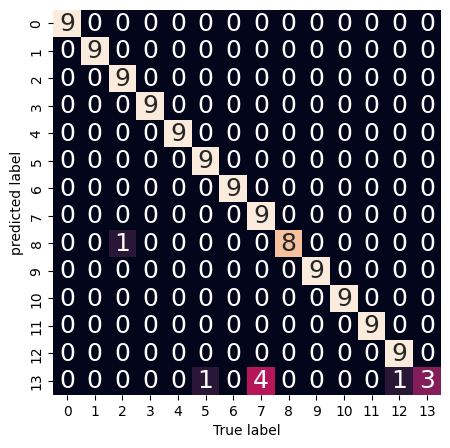

In [ ]:
import seaborn as sns

fig,ax=plt.subplots(figsize=(5,5))
sns.set(font_scale=1.5)

conf_mat=confusion_matrix(actual_label,predicted_label)

ax=sns.heatmap(conf_mat,annot=True,cbar=False);
plt.xlabel('True label');
plt.ylabel('predicted label');

In [ ]:
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score,accuracy_score

print(classification_report(actual_label,predicted_label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         9
           2       0.90      1.00      0.95         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9
           5       0.90      1.00      0.95         9
           6       1.00      1.00      1.00         9
           7       0.69      1.00      0.82         9
           8       1.00      0.89      0.94         9
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00         9
          12       0.90      1.00      0.95         9
          13       1.00      0.33      0.50         9

    accuracy                           0.94       126
   macro avg       0.96      0.94      0.94       126
weighted avg       0.96      0.94      0.94       126



In [ ]:
print(f"Accuracy:{accuracy_score(actual_label,predicted_label)*100 }")
print(f"Precision : {precision_score(actual_label,predicted_label,pos_label='positive',average='micro')}")
print(f"Recall : {recall_score(actual_label,predicted_label,pos_label='positive',average='micro')}")
print(f"f1-score:{f1_score(actual_label,predicted_label, average='micro')}")

Accuracy:94.44444444444444
Precision : 0.9444444444444444
Recall : 0.9444444444444444
f1-score:0.9444444444444444


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [ ]:
saveModelToJson(finalModel)

Model saved as /content/output/model.json


In [ ]:
from PIL import Image

def loadSingleImage(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

In [ ]:
image_path='/content/drive/MyDrive/finalYear/dataset/validation/Ah/scene100436.png'

In [ ]:
image =loadSingleImage(image_path)

In [ ]:
def showImageCV(preds, imagePath, letter=None):
    # find the class label index with the largest corresponding
    # probability
    i = preds.argmax(axis=1)[0]
    # label = lb.classes_[i]
    # draw the class label + probability on the output image
    text = "{}: {:.2f}%".format(list(class_labels.keys())[np.argmax(preds[0])], preds[0][i] * 100)

    image = cv2.imread(imagePath)
    output = image.copy()
    cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                (0, 0, 255), 2)
    # show the output image
    cv2_imshow(output)
    cv2.waitKey(0)


In [ ]:
predict= model2.predict(image)
print(np.argmax(predict))
predicted= get_pred_label(predict)
predicted

In [ ]:
showImageCV(predict,image_path)
